<h1 align = "center">Univariate LSTM Network</h1>

---


**Objective:** Create a *bare neural network* LSTM model for univariate time series data and check the functionalities and capabilities. Note the model developed here are just for informational purpose and the actual model is to be developed and trained in cloud. The notebook also serves as a reference to all the *beautiful* custom-built user-defined functionalities available.

## Prediction of Future Sequence

A LSTM network can be developed to predict future sequence of a given length (defined as **`n_forecast`**) by - (I) creating a output layer (generally `Dense`) of `length == n_forecast`, as described [here](https://stackoverflow.com/a/69912334/6623589), or (II) create a function that takes previous input and keep on iterating for `n_forecast` as in [this video](https://youtu.be/UbvkhuqVqUI?t=1026). In this notebook, both the approach is tried however the accuracy metric and performance comparison are to be added later. The `n_lookup` and `n_forecast` can be explained as in:

![prediction-sequence](https://i.stack.imgur.com/YXwMJ.png)

where, $T$ is the lookback period defined as **`n_lookup`** throught the code, and $H$ is the forecast period defined as **`n_forecast`**.

### Lookback Period (`n_lookup`)

The day's considered while model training. Based on *previous analysis* it is observed that past fifteen (15) days data has an impact on the bid execution day (i.e. $D_{t_{1}}$) thus for model training we can cosider a sequence of shape `(-1, 15 * 96, 1)` where `96` is the number of blocks for a day. Thus, `n_lookup` will take a sequence data comprising of $D_{t_{-16}}$ to $D_{t_{-2}}$ while sitting on $D_{t_{-1}}$ to predict.

### Forecast Period (`n_forecast`)

Sitting on $D_{t_{-1}}$ to predict, the bids are to be placed on $D_{t_{0}}$ for $D_{t_{1}}$ thus we need `2 * 96 = 192` worth sequence of data. While some data may already available, this needs more clarifications and thus total data of $D_{t_{0}}$ is neglected for all markets.

In [1]:
# use the code release version for tracking and code modifications. use the
# CHANGELOG.md file to keep track of version features, and/or release notes.
# the version file is avaiable at project root directory, check the
# global configuration setting for root directory information.
# the file is already read and is available as `__version__`
__version__ = open("../VERSION", "rt").read() # bump codecov
print(f"Current Code Version: {__version__}") # TODO : author, contact

Current Code Version: #ideation v0.0.1-alpha (#semver v2.0.0)


## Code Imports

A code must be written such that it is always _production ready_. The conventional guidelines provided under [**PEP8**](https://peps.python.org/pep-0008/#imports) defines the conventional or syntactically useful ways of defining and/or manipulating functions. Necessar guidelines w.r.t. code imports are mentioned below, and basic libraries and import settings are defined.

 1. Imports should be on separate lines,
 2. Import order should be:
    * standard library/modules,
    * related third party imports,
    * local application/user defined imports
 3. Wildcard import (`*`) should be avoided, else specifically tagged with **`# noqa: F403`** as per `flake8` or **`# pylint: disable=unused-import`** as per `pylint`
 4. Avoid using relative imports; use explicit imports instead.

In [2]:
import os   # miscellaneous os interfaces
import sys  # configuring python runtime environment
import time # library for time manipulation, and logging

In [3]:
# use `datetime` to control and preceive the environment
# in addition `pandas` also provides date time functionalities
import datetime as dt

In [4]:
from copy import deepcopy      # dataframe is mutable
# from tqdm import tqdm as TQ    # progress bar for loops
# from uuid import uuid4 as UUID # unique identifier for objs

### Data Analysis and AI/ML Libraries

Import of data analysis and AI/ML libraries required at different intersections. Check settings and configurations [here](https://gitlab.com/ZenithClown/computer-configurations-and-setups) and code snippets [here](https://gitlab.com/ZenithClown/computer-configurations-and-setups/-/tree/master/template/snippets/vscode) for understanding settings that is used in this notebook. The code uses `matplotlib.styles` which is a custom `.mplstyle` file recognised by the `matplotlib` downlodable from [this link](https://gitlab.com/ZenithClown/computer-configurations-and-setups/-/tree/master/settings/python/matplotlib).

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style');

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 15) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.3f}'.format # float precisions

In [6]:
import xlwings as xw # https://www.xlwings.org/

In [7]:
# for rmse, use `squared = False` : https://stackoverflow.com/a/18623635/
from sklearn.metrics import (
    mean_squared_error as MSE,
    mean_absolute_error as MAE
)

In [8]:
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}", end = "\n") # required >= 2.8

# check physical devices, and gpu compute capability (if available)
if len(tf.config.list_physical_devices(device_type = "GPU")):
    # https://stackoverflow.com/q/38009682/6623589
    # https://stackoverflow.com/a/59179238/6623589
    print("GPU Computing Available.", end = " ")
    
    # experimentally, get the gpu details and computation power
    # https://www.tensorflow.org/api_docs/python/tf/config/experimental/get_device_details
    devices = tf.config.list_physical_devices(device_type = "GPU")[0] # first
    details = tf.config.experimental.get_device_details(devices) # only first
    details.get('device_name', 'compute_capability')
    print(f"EXPERIMENTAL : {details}")
else:
    print("GPU Computing Not Available. If `GPU` is present, check configuration. Detected Devices:")
    print("  > ", tf.config.list_physical_devices())

Tensorflow Version: 2.9.0
GPU Computing Available. EXPERIMENTAL : {'device_name': 'NVIDIA GeForce GTX 1650', 'compute_capability': (7, 5)}


### User Defined Function(s)

It is recommended that any UDFs are defined outside the scope of the *jupyter notebook* such that development/editing of function can be done more practically. As per *programming guidelines* as [`src`](https://fileinfo.com/extension/src) file/directory is beneficial in code development and/or production release. However, *jupyter notebook* requires *kernel restart* if any imported code file is changed in disc, for this frequently changing functions can be defined in this section.

**Getting Started** with **`PYTHONPATH`**

One must know what are [Environment Variable](https://medium.com/chingu/an-introduction-to-environment-variables-and-how-to-use-them-f602f66d15fa) and how to call/use them in your choice of programming language. Note that an environment variable is *case sensitive* in all operating systems (except windows, since DOS is not case sensitive). Generally, we can access environment variables from terminal/shell/command prompt as:

```shell
# macOS/*nix
echo $VARNAME

# windows
echo %VARNAME%
```

Once you've setup your system with [`PYTHONPATH`](https://bic-berkeley.github.io/psych-214-fall-2016/using_pythonpath.html) as per [*python documentation*](https://docs.python.org/3/using/cmdline.html#envvar-PYTHONPATH) is an important directory where any `import` statements looks for based on their order of importance. If a source code/module is not available check necessary environment variables and/or ask the administrator for the source files. For testing purpose, the module boasts the use of `src`, `utils` and `config` directories. However, these directories are available at `ROOT` level, and thus using `sys.path.append()` to add directories while importing.

In [9]:
# append `src` and sub-modules to call additional files these directory are
# project specific and not to be added under environment or $PATH variable
# sys.path.append(os.path.join("..", "src")) # parent/source files directory
# sys.path.append(os.path.join("..", "src", "agents")) # agents for reinforcement modelling
sys.path.append(os.path.join("..", "src", "engine")) # derivative engines for model control
# sys.path.append(os.path.join("..", "src", "models")) # actual models for decision making tools

In [10]:
# also append the `utilities` directory for additional helpful codes
sys.path.append(os.path.join("..", "utilities"))

In [11]:
from plotting import * # noqd: F403 # pylint: disable=unused-import
from scaler import UnivariateRangedScaler

## Global Argument(s)

The global arguments are *notebook* specific, however they may also be extended to external libraries and functions on import. The *boilerplate* provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.

In [12]:
ROOT = ".." # the document root is one level up, that contains all code structure
DATA = os.path.join(ROOT, "data") # the directory contains all data files, subdirectory (if any) can also be used/defined

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = os.path.join(DATA, "processed")

In [13]:
# long projects can be overwhelming, and keeping track of files, outputs and
# saved models can be intriguing! to help this out, `today` can be used. for
# instance output can be stored at `output/<today>/` etc.
# `today` is so configured that it permits windows/*.nix file/directory names
today = dt.datetime.strftime(dt.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y"), "%a, %b %d %Y")
print(f"Code Execution Started on: {today}") # only date, name of the sub-directory

Code Execution Started on: Tue, Feb 21 2023


In [14]:
OUTPUT_DIR = os.path.join(ROOT, "output") # models and images file name is defined later
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
MODELS_DIR = os.path.join(OUTPUT_DIR, "savedmodels")

## Read Input File(s)

A typical machine learning project revolves around six important stages (as available in [Amazon ML Life Cycle Documentation](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/well-architected-machine-learning-lifecycle.html)). The notebook boilerplate is provided to address two pillars:

 1. **Data Processing:** An integral part of any machine learning project, which is the most time consuming step! A brief introduction and best practices is available [here](https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d).
 2. **Model Development:** From understanding to deployment, this section address development (training, validating and testing) of an machine learning model.

![ML Life Cycle](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/images/ml-lifecycle.png)

In [15]:
market_snapshot = pd.read_pickle(os.path.join(PROCESSED_DATA, "df_consolidated_2012-04-01_2022-12-31.pickle"))
market_snapshot.sample()

,EffectiveDate,year,month,day,BlockID,PurchaseBid,SellBid,MCV,MCP,scaled(MCP)
328876,2021-08-18,2021,8,18,77,"16,597.100","9,064.500","9,064.500","11,000.750",1.548


### Training Data Arguments

Training `data` is read directly from *preprocessed* files (check internal code notebooks for more information) and certain arguments are defined which are required later by the model or during testing/validation.

In [16]:
START_DATE = dt.datetime(year = 2019, month = 4, day = 1)
FINAL_DATE = dt.datetime(year = 2022, month = 10, day = 31)
# data = market_snapshot[(market_snapshot["EffectiveDate"] >= START_DATE) & (market_snapshot["EffectiveDate"] <= FINAL_DATE)]["scaled(MCP)"].values

### Data Formatting for ML Model

Load reshaped data for training. Check internal code for more information.

In [17]:
n_lookback = 3 * 96 # 🧪 look into 7 days past records
n_forecast = 2 * 96 # on t(-1) we want prediction for t(+1)

In [18]:
# with open(os.path.join(PROCESSED_DATA, "xy_train_consolidated_2019-04-01_2022-10-31_n_lookback_288_n_forecast_192.npy"), "rb") as fileObj:
#     x_train = np.load(fileObj)
#     y_train = np.load(fileObj)

# print(f"Processed Data Format: {x_train.shape, y_train.shape}")

## Model Development

The model is developed and trained using *user-defined* functions available typically under **`src`**, which makes it easier to keep all the codes and functionalities same, and just change the model and input to suit the need and easily switch between R&D, testing and production environment. **Model is trained using `trainer.py` and is directly loaded.**

In [19]:
model = tf.keras.models.load_model(os.path.join(MODELS_DIR, "2023-01-21 BareLSTM-1.0.0.h5"))
inverse_scaler = UnivariateRangedScaler(x_min = 0.10 * 1e3, x_max = 12.00 * 1e3, feature_range = (1, 2))

### Model Evaluation

In the below section, we evaluate the model performance based on various factors.

**Known Data Block(s)**

In [20]:
TEST_START_DAY = dt.datetime(year = 2022, month = 9, day = 24)
TEST_FINAL_DAY = dt.datetime(year = 2022, month = 9, day = 26)

PREDICTION_START_DAY = dt.datetime(year = 2022, month = 9, day = 27)
PREDICTION_FINAL_DAY = dt.datetime(year = 2022, month = 9, day = 28)

test_data = market_snapshot[(market_snapshot["EffectiveDate"] >= TEST_START_DAY) & (market_snapshot["EffectiveDate"] <= TEST_FINAL_DAY)]
pred_data = market_snapshot[(market_snapshot["EffectiveDate"] >= PREDICTION_START_DAY) & (market_snapshot["EffectiveDate"] <= PREDICTION_FINAL_DAY)]

# define y_test and y_actual for model performance and analysis
y_test_ = test_data["scaled(MCP)"].values.reshape(-1, n_lookback, 1)
y_actual_ = pred_data["MCP"].values
y_actual_sc_ = pred_data["scaled(MCP)"].values

In [21]:
y_predicted = model.predict(y_test_)[0]

# calculate the mae and rmse loss for the model as:
print(f"""
Error Analysis Report
=====================
  Mean Absolute Error (MAE)      : {MAE(y_actual_sc_, y_predicted):.5f}
  Root Mean Squared Error (RMSE) : {MSE(y_actual_sc_, y_predicted, squared = False):.5f}
""")

1/1 [==============================] - 1s 1s/step

Error Analysis Report
  Mean Absolute Error (MAE)      : 0.13581
  Root Mean Squared Error (RMSE) : 0.19299



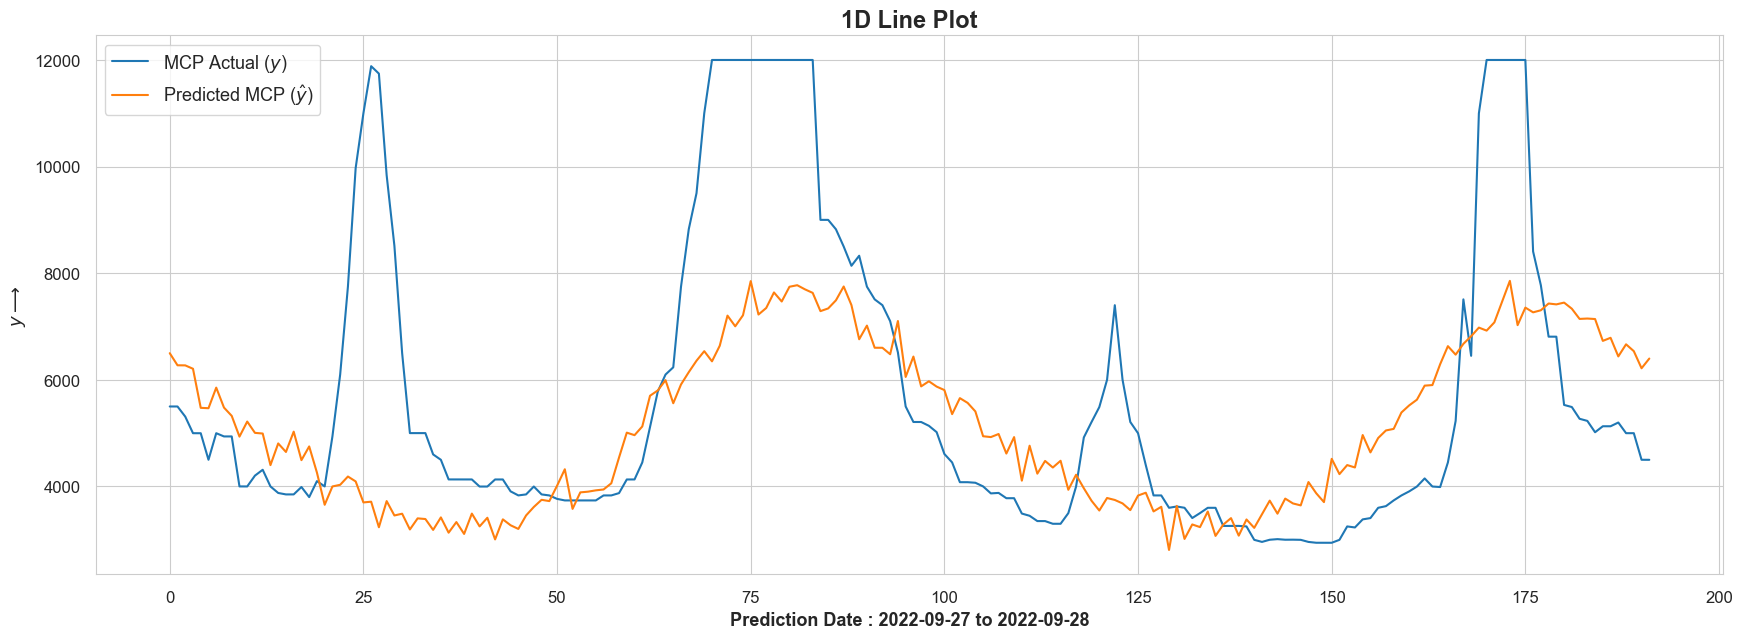

In [23]:
lineplot_1d(
    x = np.array(list(zip(y_actual_, inverse_scaler.inverse_transform(y_predicted)))),
    xticks = None, # list(map(lambda x : f"{x[0].date()} [{x[1]}]", pred_data[["EffectiveDate", "BlockID"]].values)),
    legends = ["MCP Actual ($y$)", "Predicted MCP ($\hat{y}$)"],
    xlabel = f"Prediction Date : {PREDICTION_START_DAY.date()} to {PREDICTION_FINAL_DAY.date()}"
    ylabel = "Market Clearing Price (MCP) $\longrightarrow$"
)

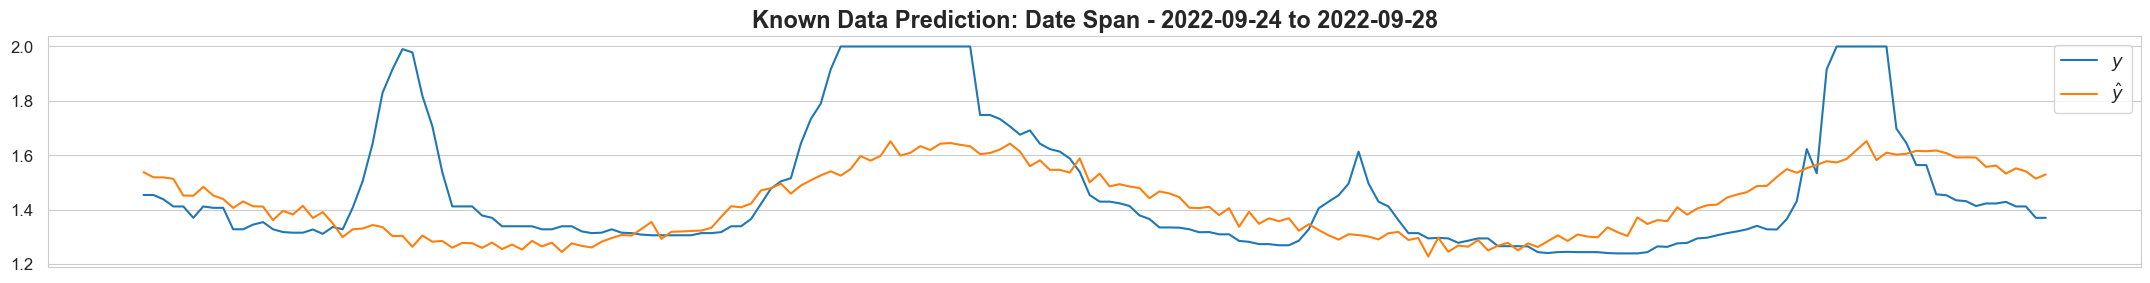

In [24]:
plt.figure(figsize = (27, 3))

plt.plot(y_actual_, label = "")
plt.plot(y_predicted, label = "$\hat{y}$")

plt.xticks([]) # close for now
plt.title(f"Known Data Prediction: Date Span - {TEST_START_DAY.date()} to {PREDICTION_FINAL_DAY.date()}")
plt.legend()
plt.show()

**Unknown Data Block(s)**

In [ ]:
TEST_START_DAY = dt.datetime(year = 2022, month = 11, day = 5)
TEST_FINAL_DAY = dt.datetime(year = 2022, month = 11, day = 7)

PREDICTION_START_DAY = dt.datetime(year = 2022, month = 11, day = 8)
PREDICTION_FINAL_DAY = dt.datetime(year = 2022, month = 11, day = 9)

test_data = market_snapshot[(market_snapshot["EffectiveDate"] >= TEST_START_DAY) & (market_snapshot["EffectiveDate"] <= TEST_FINAL_DAY)]["scaled(MCP)"].values
y_actual_ = market_snapshot[(market_snapshot["EffectiveDate"] >= PREDICTION_START_DAY) & (market_snapshot["EffectiveDate"] <= PREDICTION_FINAL_DAY)]["scaled(MCP)"].values

In [ ]:
y_predicted = model.predict(test_data.reshape(-1, n_lookback, 1))[0]

# calculate the mae and rmse loss for the model as:
print(f"""
Error Analysis Report
=====================
  Mean Absolute Error (MAE)      : {MAE(y_actual_, y_predicted):.5f}
  Root Mean Squared Error (RMSE) : {MSE(y_actual_, y_predicted, squared = False):.5f}
""")

In [ ]:
plt.figure(figsize = (27, 3))

plt.plot(y_actual_, label = "$y$")
plt.plot(y_predicted, label = "$\hat{y}$")

plt.xticks([]) # close for now
plt.title(f"Known Data Prediction: Date Span - {TEST_START_DAY.date()} to {PREDICTION_FINAL_DAY.date()}")
plt.legend()
plt.show()

## Generate Internal Report

In [ ]:
wb = xw.Book(os.path.join(ROOT, "static", "template", r"Internal Statistical Reporting Template.xlsx"))

# fill the code meta information
wb.sheets["about"]["K7"].value = __version__ # code version
wb.sheets["about"]["K8"].value = f"Tensorflow (v{tf.__version__}) with Keras Backend"
wb.sheets["about"]["K9"].value = "ideation phase"

# add the model summary as a data frame with various other informations
wb.sheets["about"]["A15"].value = pd.DataFrame(data = {
    "Model Name" : [model.name],
    "Model Path" : [MODEL_SAVEPATH],
    "Model Performance Metric" : [PERFORMANCE_IMAGE_PATH],
    
    # now add the current testing metric information
    "Testing Data Range"   : [(TEST_START_DAY, TEST_FINAL_DAY)],
    "Bidding (t0) Date"    : [PREDICTION_START_DAY],
    "Prediction (t1) Date" : [PREDICTION_FINAL_DAY]
}).set_index(["Model Name"])


wb.sheets["Testing Dataset"]["A3"].options(header = None).value = market_snapshot[(market_snapshot["EffectiveDate"] >= TEST_START_DAY) & (market_snapshot["EffectiveDate"] <= TEST_FINAL_DAY)].set_index("EffectiveDate").drop(columns = ["year", "month", "day"])

# save file as new file
wb.save(os.path.join(OUTPUT_DIR, "Template Integration Testing.xlsx"))
# wb.close() # uncomment to auto-close file